# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import numpy as np
import speckleret as spr

Load the interferometric data

In [287]:
def load_image_from_txt(filepath: str, width: int = 1936, height: int = 1216, header_lines: int = 21) -> np.ndarray:
    """
    Load pixel data from a text file into a NumPy array.

    Args:
        filepath (str): Path to the .txt file.
        width (int): Image width in pixels.
        height (int): Image height in pixels.
        header_lines (int): Number of header lines to skip.

    Returns:
        np.ndarray: 2D array of shape (height, width) containing the image data.
    """
    with open(filepath, "r") as f:
        lines = f.readlines()

    # Skip header lines
    pixel_lines = lines[header_lines:]

    # Join all lines and convert to integer array
    pixel_str = " ".join(pixel_lines)
    pixels = np.fromstring(pixel_str, sep=' ', dtype=int)

    # Reshape to image
    height = pixels.size / width
    return pixels.reshape((int(height), int(width)))

path = r'C:\Users\saucourt\Downloads\3_7_2025_DATA'
date = '390'

img_width = 512
half_img_width = img_width // 2
nf_central_row = 700
nf_central_col = 1070
ff_central_row = 565
ff_central_col = 860


CP = load_image_from_txt(os.path.join(path, date + 'N.txt'))[(nf_central_row-half_img_width):(nf_central_row+half_img_width), (nf_central_col-half_img_width):(nf_central_col+half_img_width)]
CL = load_image_from_txt(os.path.join(path, date + 'F.txt'))[(ff_central_row-half_img_width):(ff_central_row+half_img_width), (ff_central_col-half_img_width):(ff_central_col+half_img_width)]


CP = np.expand_dims(CP, axis=0)
CL = np.expand_dims(CL, axis=0)
print(CP.shape)
print(CL.shape)

(1, 512, 512)
(1, 512, 512)


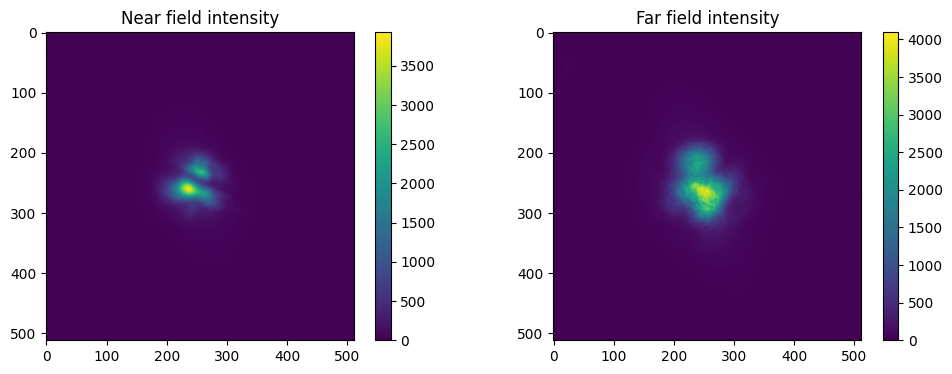

In [288]:
idx = 0

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(CP[idx, ...], vmin=0)
plt.title('Near field intensity')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(CL[idx, ...], vmin=0)
plt.title('Far field intensity')
plt.colorbar()

### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

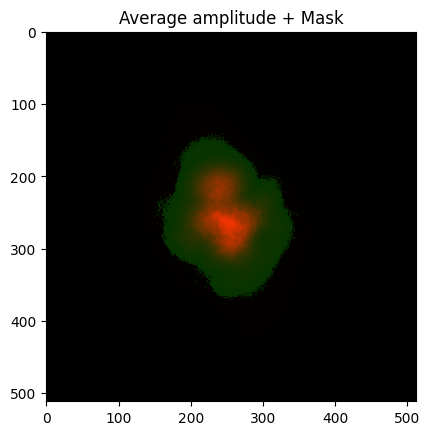

20.64002227783203


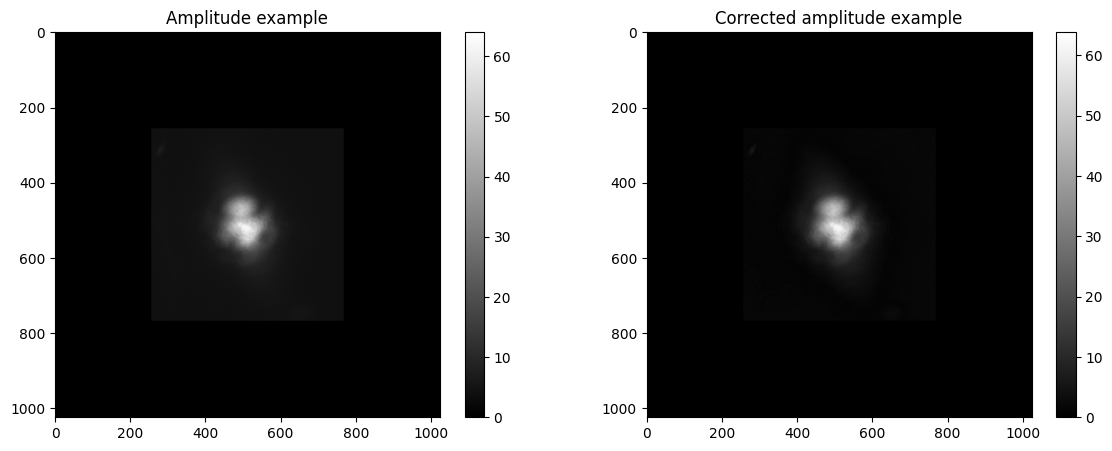

In [289]:
noise_corr = spr.utils.extract_noise_correction(CL, averaging_axis=(0,), mask_trsh=0.02, plot_result=True, plot_mask=True)
print(noise_corr)

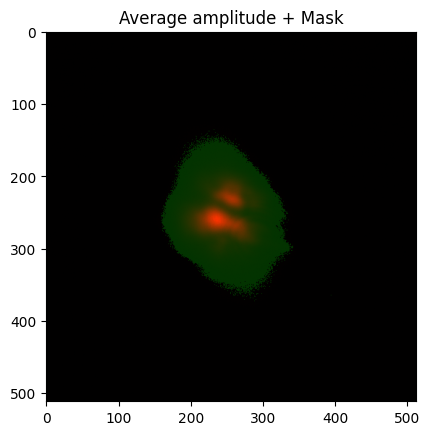

17.261737823486328


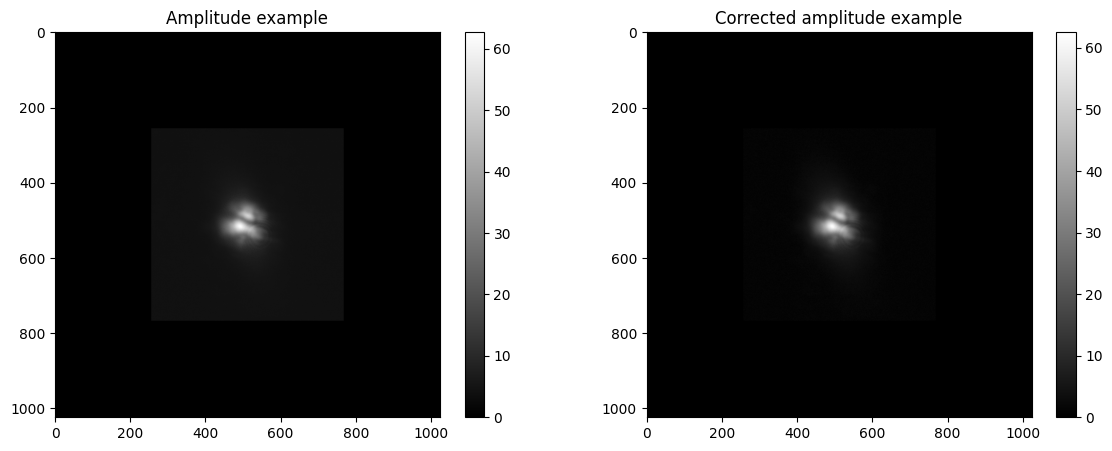

In [290]:
noise_corrCP = spr.utils.extract_noise_correction(CP, averaging_axis=(0,), mask_trsh=0.01, plot_mask=True, plot_result=True)
print(noise_corrCP)

Let's detect the average centroids

In [291]:
centroids_CP = spr.utils.extract_average_centroid(CP, averaging_axis=(-1, -2))
centroids_CL = spr.utils.extract_average_centroid(CL, averaging_axis=(-1, -2))

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (0.0, 256.0403839770528)
Average centroid CL: (0.0, 256.6457432501076)


### Data preparation

Select data for phase retrieval

774
(774, 774) 2664400.645854392
(774, 774) 5585081.757001919


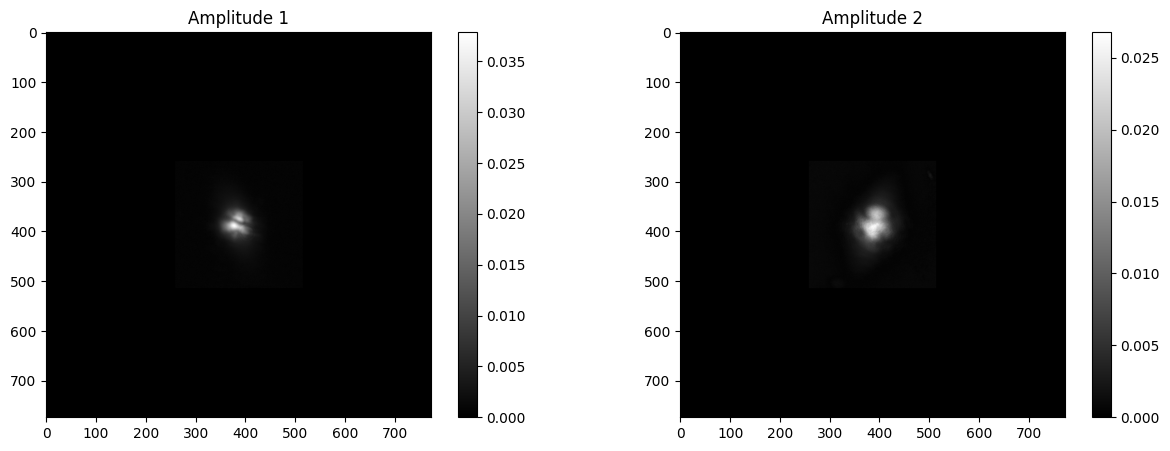

In [313]:
idx = 0
random: bool = False
if random:
    idx = np.random.randint(0, len(CP))


def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))

bin_cp = 2
bin_cl = 2
N_window = compute_N_win(1064e-9, 100e-3, bin_cp * 5.86e-6, bin_cl * 5.86e-6)
print(N_window)


field = np.sqrt(np.abs(CP[idx, ...] - noise_corrCP)) #

# CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = spr.utils.bin_image(field, factor=bin_cp)
f_shape = field.shape
f_pad = (N_window - f_shape[0]) // 2
field = np.pad(field, [f_pad, f_pad])

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(np.abs(CL[idx, ...] - noise_corr)) #
# CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
# ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
ft = spr.utils.bin_image(ft, factor=bin_cl)
ft_shape = ft.shape
ft_pad = (N_window - ft_shape[0]) // 2
ft = np.pad(ft, [ft_pad, ft_pad])
# ft = np.flip(ft, axis=0)
ft = np.flip(ft, axis=1)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

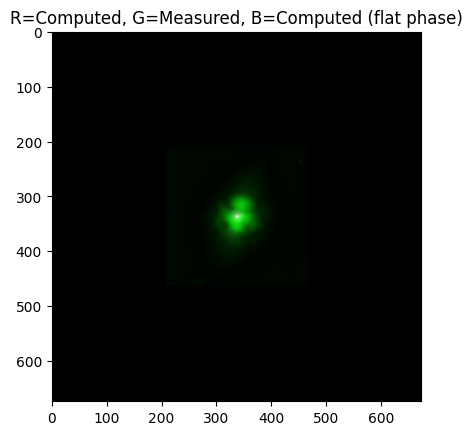

In [314]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = 50

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

Define the phase retrieval support

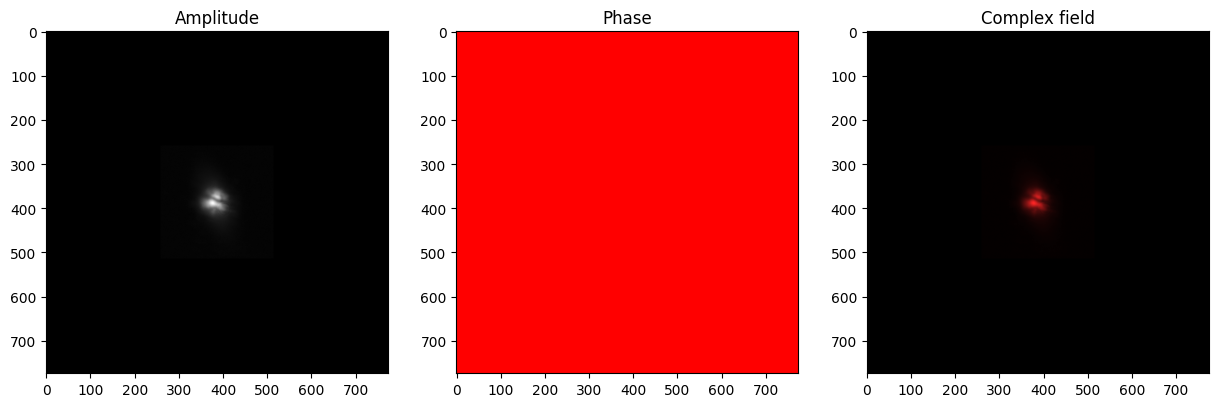

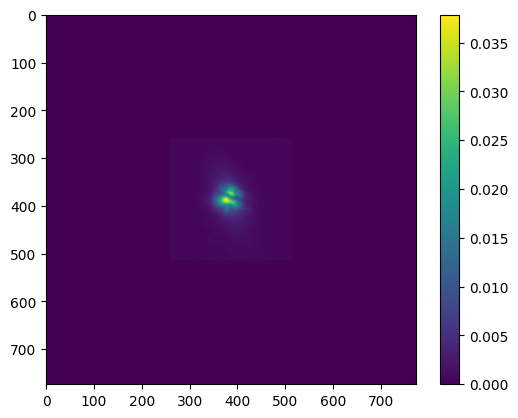

In [315]:
support = spr.supports.threshold_support(field, threshold=0.00)
# support = spr.supports.disk_support(field, radius=90, offsets=(0,0))
supported_field = field.copy()
supported_field[np.logical_not(support)] = np.nan
_ = spr.plots.complex_imshow(supported_field)

plt.figure()
plt.imshow(supported_field)
plt.colorbar()

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

In [316]:
from matplotlib.colors import hsv_to_rgb

def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = np.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

In [ ]:
from speckleret.transforms import fourier_transform

results = []

# x, result = spr.retrievalmath.run(
#         magnitudes=(np.abs(field), np.abs(ft)),
#         support=support,
#         init=spr.initializers.flat_phases(magnitude=np.abs(field)),
#         # init=x,
#         algorithm=spr.retrievalmath.OSS,
#         algorithm_kwargs={'beta': 0.7, 'sigma': 1.0, 'filter_decay': 0.99},
#         max_iter=500,
#         rel_tol=1e-6,
# )
# results.append(result)

x, result = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        # init=x,
        # init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        init=spr.initializers.random_phases(magnitude=np.abs(field)),
        algorithm=spr.retrievalmath.RAAR,
        algorithm_kwargs={'beta': 0.99},
        max_iter=200,
        rel_tol=1e-6,
)
results.append(result)

x, result = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        # init=spr.initializers.random_phases(magnitude=np.abs(field)),
        init=x,
        algorithm=spr.retrievalmath.ER,
        max_iter=100,
        rel_tol=1e-6,
)
results.append(result)

for i in range(1):
        x, result = spr.retrievalmath.run(
                magnitudes=(np.abs(field), np.abs(ft)),
                support=support,
                init=x,
                algorithm=spr.retrievalmath.RAAR,
                algorithm_kwargs={'beta': 0.99},
                max_iter=200,
                rel_tol=1e-6,
        )
        results.append(result)

        x, result = spr.retrievalmath.run(
                magnitudes=(np.abs(field), np.abs(ft)),
                support=support,
                init=x,
                algorithm=spr.retrievalmath.ER,
                max_iter=100,
                rel_tol=1e-6,
        )
        results.append(result)


spr.retrievalmath.report_convergence_results(merge_dicts(results))
plt.show()

x_hat = x
y_hat = fourier_transform(x_hat)

spr.retrievalmath.show_retrieved_fields(field, ft, x_hat, y_hat, power=2, window_crop=60)

In [68]:
np.savez(
    file=os.path.join(path, 'PR_speckles_' + date + f'_idx={idx}' + '.npz'),
    field=field, fourier=ft, retrieved_field=x_hat, retrieved_fourier=y_hat, pr_results=results,
)